# **FAKE NEW DETECTION**

### About Project
  - Developing a model to classify articles into two labels: 'TRUE' and 'FAKE,' using BiLSTM model for the Vietnamese language.
  - Dataset: https://drive.google.com/drive/folders/1_zFH0qkS0_NGxezGz18muR0Jw-ZdWias?usp=sharing
### About Data
  - Include 3000 articles Fake News and 3000 articles  Real News with 3 columns Title, URL and Content
  - Real data is crawled from Thanh Nien Magazine, Dan Tri, Tuoi Tre
  - Fake data is crawled from Khoi8406, Viet Tan
  - Label:
   + 0: Real
   + 1: Fake

# **Load data and import Library**

### Import library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00


In [3]:
!pip install transformers

In [4]:
import pandas as pd
import nltk
import re
import sklearn.feature_extraction.text as text
from collections import Counter
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyvi import ViTokenizer
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import pickle
import tensorflow as tf
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import model_selection

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load data

In [5]:
file = '/content/drive/MyDrive/PBL6/final.csv'
data = pd.read_csv(file)

In [6]:
data.head(3)

,Title,URL,Content,Label
0,LÝ DO EXONMOBIL CÓ THỂ RỜI KHỎI VIỆT NAM (Tim ...,https://www.khoi8406.com/post/nhanquyenchovn/l...,"Kể từ khi lên cầm quyền vào năm 2013, Tậ...",1.0
1,TỔNG THỐNG TRUMP PHẢI TRẢ ĐŨA IRAN (Ngô Nhân D...,https://www.khoi8406.com/post/nhanquyenchovn/t...,Iran chủ mưu vụ tấn công vào mấy nhà máy lọc d...,1.0
2,ĐẢNG CỘNG SẢN TRUNG QUỐC SẼ SỤP ĐỔ TRƯỚC NĂM 2...,https://www.khoi8406.com/post/nhanquyenchovn/a...,"Vào ngày 1 tháng 10, để kỷ niệm 70 năm ngày th...",1.0


# **Processing**

### Remove null and NaN

In [7]:
data.isnull().sum()

Title       0
URL         0
Content    20
Label       4
dtype: int64

In [8]:
df = data.dropna()
df = df.drop(df[df['Content']=='* · '].index)

In [9]:
df.isnull().sum()

Title      0
URL        0
Content    0
Label      0
dtype: int64

Data Before and After remove null and NaN

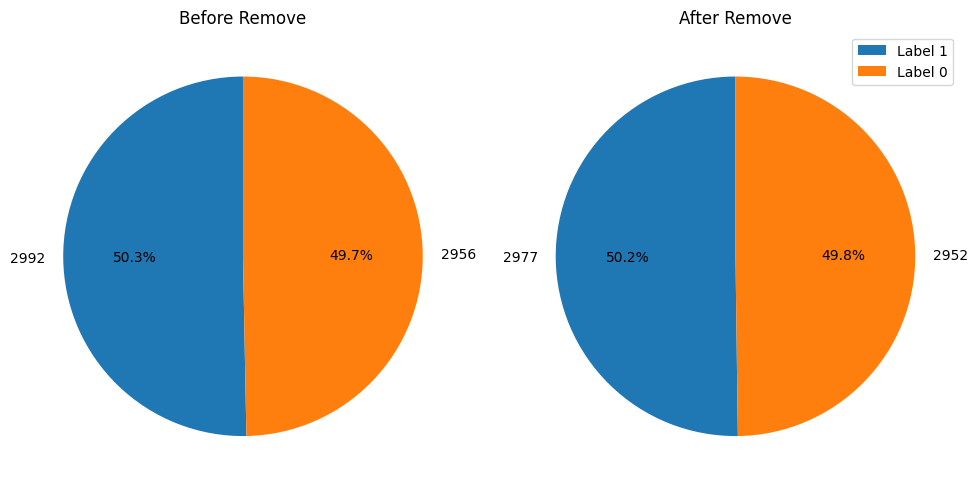

In [10]:
# data quantity chart
def quantity_chart():
    counts_df1 = data['Label'].value_counts()
    counts_df2 = df['Label'].value_counts()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.pie(counts_df1, labels=counts_df1, autopct='%1.1f%%', startangle=90)
    plt.title('Before Remove')

    plt.subplot(1, 2, 2)
    plt.pie(counts_df2, labels=counts_df2, autopct='%1.1f%%', startangle=90)
    plt.title('After Remove')

    labels = ['Label 1', 'Label 0']
    plt.legend(labels=labels, loc="best")
    plt.tight_layout()
    plt.show()
quantity_chart()

### Cleansing Data

Read Vietnamese Stop-words file

In [11]:
with open('/content/drive/MyDrive/PBL6/vietnamese.txt', 'r', encoding = 'utf-8') as file:
    stopwords = file.read().splitlines()

Data Cleaning Functions

In [12]:
#delete numbers
def delete_numbers(text):
    return re.sub(r'\d+', ' ', text)
#lower case
def lower(text):
    return text.lower()
#delete special characters
def remove_special_characters(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!–"#$%&'()*+,،-./:;<=>؟?@[\]^`{|}~“”…"""), ' ', text)
    text = text.replace('؛',"", )
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()
#delete stop words
def remove_stopwords(text):
    words = text.split()
    mean_word = [word for word in words if word not in stopwords]
    mean_text = " ".join(mean_word)
    return mean_text
def preprocess(text):
    text = delete_numbers(text)
    text = lower(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    return text
def preprocess_nostop(text):
    text = delete_numbers(text)
    text = lower(text)
    text = remove_special_characters(text)
    return text

Compound Word and Tokenizer Functions


In [13]:
# Compound Vietnamese word
def tokenizerVN(text):
    return ViTokenizer.tokenize(text)
# Tokenizer
def tokenizer(text):
    return word_tokenize(text)
# Count token
def count_token(text):
    word = tokenizerVN(str(text))
    return len(word.split())
# Word Cloud
def top_count(dt):
    top = Counter([item for sublist in df[dt].apply(lambda x:str(x).split()) for item in sublist])
    temp = pd.DataFrame(top.most_common(50))
    temp.columns = ['Common_words','count']
    temp.style.background_gradient(cmap='Blues')
    return temp
def top_count2(dt):
    top = Counter([item for sublist in df[dt].apply(lambda x:str(x).split()) for item in sublist])
    temp = pd.DataFrame(top.most_common(50))
    temp.columns = ['Common_words_No_SW','count_SW']
    temp.style.background_gradient(cmap='Blues')
    return temp

Example

In [14]:
expamle_sentece = 'Toàn bộ @ sự việc đã được camera giám sát ghi lại 123 và sau đó chia sẻ lên mạng.Theo đó, chiếc Corvette màu đỏ đang yên vị trên cầu nâng thì phần đuôi xe bắt đầu trượt, rồi cả chiếc xe rơi xuống đất'

In [15]:
sentence = tokenizerVN(expamle_sentece)
print('Tokenizer:')
print(sentence)
print('----------------')
print('No remove stop word:')
print(preprocess_nostop(sentence))
print('----------------')
print('Have remove stop word:')
print(preprocess(sentence))

Tokenizer:
Toàn_bộ @ sự_việc đã được camera giám_sát ghi lại 123 và sau đó chia_sẻ lên mạng . Theo đó , chiếc Corvette màu đỏ đang yên_vị trên cầu nâng thì phần đuôi xe bắt_đầu trượt , rồi cả chiếc xe rơi xuống đất
----------------
No remove stop word:
toàn_bộ sự_việc đã được camera giám_sát ghi lại và sau đó chia_sẻ lên mạng theo đó chiếc corvette màu đỏ đang yên_vị trên cầu nâng thì phần đuôi xe bắt_đầu trượt rồi cả chiếc xe rơi xuống đất
----------------
Have remove stop word:
toàn_bộ sự_việc camera giám_sát ghi chia_sẻ mạng corvette màu đỏ yên_vị cầu nâng đuôi xe bắt_đầu trượt xe rơi đất


Apply on data

In [16]:
df['Compound_Content'] = df['Content'].apply(tokenizerVN)
df['Compound_Content_No_SW'] = df['Compound_Content'].apply(preprocess)
df['Compound_Content_SW'] = df['Compound_Content'].apply(preprocess_nostop)

In [17]:
df.head(3)

,Title,URL,Content,Label,Compound_Content,Compound_Content_No_SW,Compound_Content_SW
0,LÝ DO EXONMOBIL CÓ THỂ RỜI KHỎI VIỆT NAM (Tim ...,https://www.khoi8406.com/post/nhanquyenchovn/l...,"Kể từ khi lên cầm quyền vào năm 2013, Tậ...",1.0,"Kể từ khi lên cầm_quyền vào năm 2013 , Tập_Cận...",cầm_quyền tập_cận_bình đẩy_mạnh hiện_diện trun...,kể từ khi lên cầm_quyền vào năm tập_cận_bình đ...
1,TỔNG THỐNG TRUMP PHẢI TRẢ ĐŨA IRAN (Ngô Nhân D...,https://www.khoi8406.com/post/nhanquyenchovn/t...,Iran chủ mưu vụ tấn công vào mấy nhà máy lọc d...,1.0,Iran chủ_mưu vụ tấn_công vào mấy nhà_máy lọc d...,iran chủ_mưu vụ tấn_công mấy nhà_máy lọc dầu ả...,iran chủ_mưu vụ tấn_công vào mấy nhà_máy lọc d...
2,ĐẢNG CỘNG SẢN TRUNG QUỐC SẼ SỤP ĐỔ TRƯỚC NĂM 2...,https://www.khoi8406.com/post/nhanquyenchovn/a...,"Vào ngày 1 tháng 10, để kỷ niệm 70 năm ngày th...",1.0,"Vào ngày 1 tháng 10 , để kỷ_niệm 70 năm ngày t...",kỷ_niệm thành_lập cộng_hòa nhân_dân trung_hoa ...,vào ngày tháng để kỷ_niệm năm ngày thành_lập n...


# **Visualization**

Visualize Functions

In [18]:
# Top common words column
def top_count_column(dt):
    top = Counter([item for sublist in df[dt].apply(lambda x: str(x).split()) for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words', 'count']

    # Visualization
    plt.figure(figsize=(12, 8))
    plt.barh(temp['Common_words'][::-1], temp['count'][::-1], color='skyblue')
    plt.xlabel('Count')
    plt.ylabel('Common Words')
    plt.title('Top 20 Common Words')
    plt.show()


#Count word
word_count_SW = df['Compound_Content_SW'].apply(count_token)
word_count_no_SW = df['Compound_Content_No_SW'].apply(count_token)


# Plot data distribution
def seaborn_token(word_count):
    df['Word_count_SW'] = word_count
    sns.stripplot(y='Word_count_SW', data = df , jitter=True)

    plt.ylabel('Quantity Token')
    plt.xlabel('Seaborn Strip Plot Count without stop words')

def seaborn_token_no_SW(word_count):
    df['Word_count_no_SW'] = word_count
    sns.stripplot(y='Word_count_no_SW', data =df , jitter=True)

    plt.ylabel('Quantity Token')
    plt.xlabel('Seaborn Strip Plot Count with stop words')

def word_count():
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))

    # Vẽ histogram cho từng mẫu dữ liệu trên các axes tương ứng

    axs[0].hist(df["Word_count_SW"], bins=50)
    axs[1].hist(df["Word_count_no_SW"], bins=50)

    axs[0].set_title('Word count have stop words')
    axs[1].set_title('Word count without stop words')

    # Hiển thị biểu đồ
    plt.show()

def word_cloud(df):
    plt.subplots(figsize=(20, 10))

    wordcloud = WordCloud (
                        background_color = 'white',
                        width = 512,
                        height = 384
                            ).generate(' '.join(df))
    plt.imshow(wordcloud) # image show
    plt.axis('off') # to off the axis of x and y
    plt.savefig('Plotly_World_Cloud.png')
    plt.show()

In [19]:
df.head(3)

,Title,URL,Content,Label,Compound_Content,Compound_Content_No_SW,Compound_Content_SW
0,LÝ DO EXONMOBIL CÓ THỂ RỜI KHỎI VIỆT NAM (Tim ...,https://www.khoi8406.com/post/nhanquyenchovn/l...,"Kể từ khi lên cầm quyền vào năm 2013, Tậ...",1.0,"Kể từ khi lên cầm_quyền vào năm 2013 , Tập_Cận...",cầm_quyền tập_cận_bình đẩy_mạnh hiện_diện trun...,kể từ khi lên cầm_quyền vào năm tập_cận_bình đ...
1,TỔNG THỐNG TRUMP PHẢI TRẢ ĐŨA IRAN (Ngô Nhân D...,https://www.khoi8406.com/post/nhanquyenchovn/t...,Iran chủ mưu vụ tấn công vào mấy nhà máy lọc d...,1.0,Iran chủ_mưu vụ tấn_công vào mấy nhà_máy lọc d...,iran chủ_mưu vụ tấn_công mấy nhà_máy lọc dầu ả...,iran chủ_mưu vụ tấn_công vào mấy nhà_máy lọc d...
2,ĐẢNG CỘNG SẢN TRUNG QUỐC SẼ SỤP ĐỔ TRƯỚC NĂM 2...,https://www.khoi8406.com/post/nhanquyenchovn/a...,"Vào ngày 1 tháng 10, để kỷ niệm 70 năm ngày th...",1.0,"Vào ngày 1 tháng 10 , để kỷ_niệm 70 năm ngày t...",kỷ_niệm thành_lập cộng_hòa nhân_dân trung_hoa ...,vào ngày tháng để kỷ_niệm năm ngày thành_lập n...


Top common word have stop words

In [20]:
top_count2 = top_count2("Compound_Content_SW")
top_count2.style.background_gradient(cmap='Blues')

,Common_words_No_SW,count_SW
0,và,70882
1,của,70784
2,là,55693
3,các,49364
4,có,44401
5,trong,43652
6,không,40150
7,cho,39323
8,một,38813
9,người,37407


Top common word without stop words

In [21]:
top_count = top_count("Compound_Content_No_SW")
top_count.style.background_gradient(cmap='Blues')

,Common_words,count
0,việt_nam,17093
1,mỹ,11231
2,có_thể,10151
3,trung_quốc,9698
4,hai,9427
5,dân,9207
6,đi,8872
7,đảng,6121
8,đồng,5641
9,trump,5587


Top 20 Common word horizontal bar chart have stop words

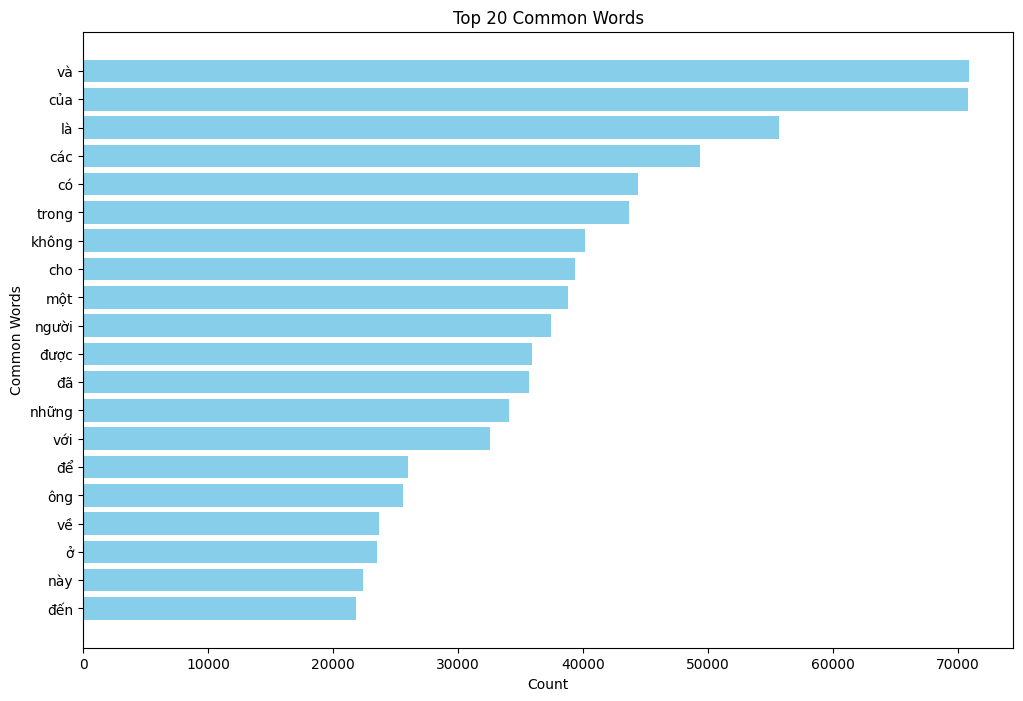

In [22]:
top_count_column('Compound_Content_SW')

Top 20 Common word horizontal bar chart without stop words

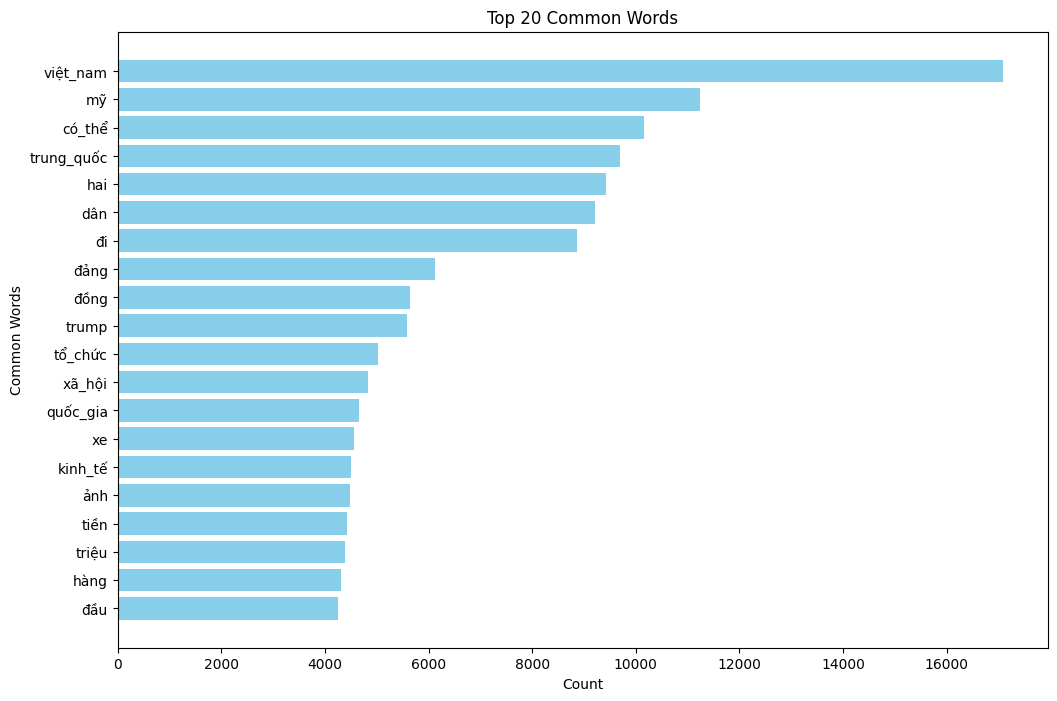

In [23]:
top_count_column('Compound_Content_No_SW')

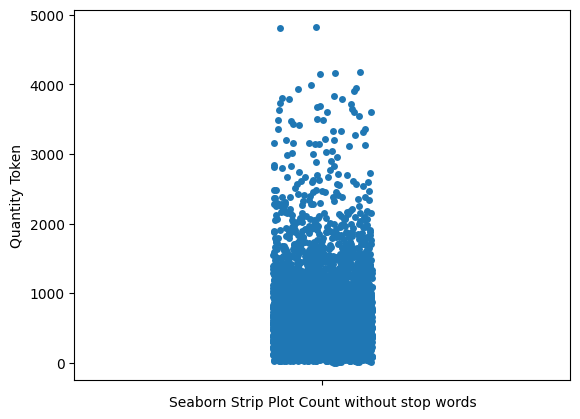

In [24]:
seaborn_token(word_count_SW)

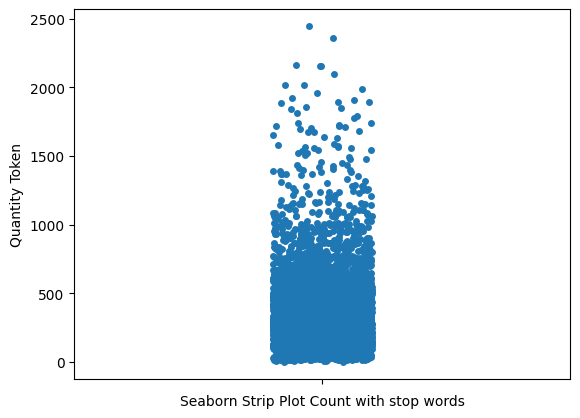

In [25]:
seaborn_token_no_SW(word_count_no_SW)

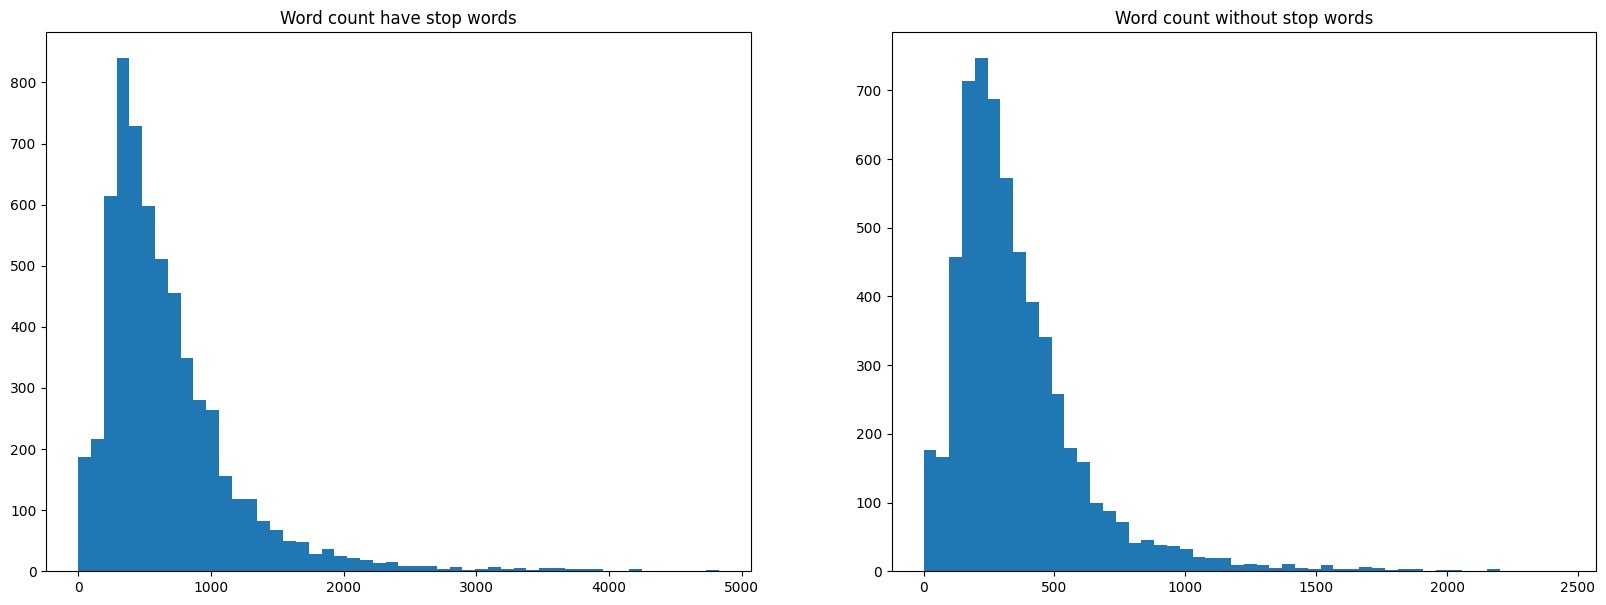

In [26]:
word_count()

Word Cloud

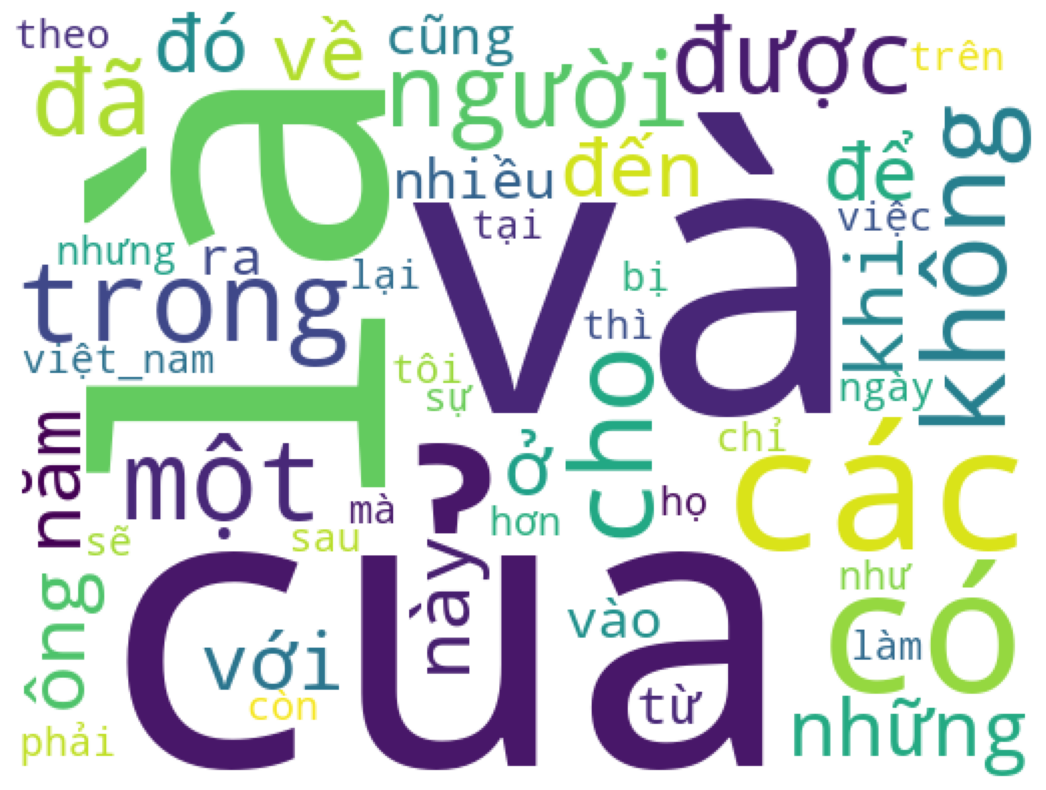

In [27]:
word_cloud(top_count2['Common_words_No_SW'])

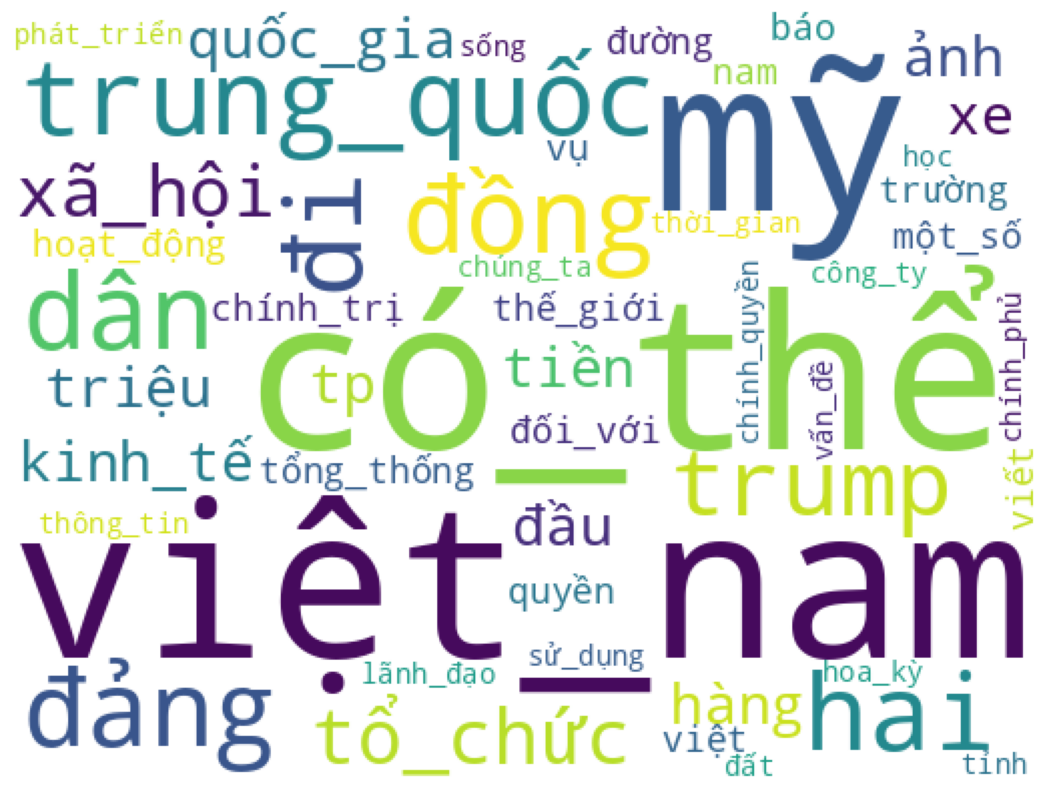

In [28]:
word_cloud(top_count['Common_words'])

## Word Embedding

In [29]:
# df['Compound_Content_No_SW'].astype(str)

In [30]:
# train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])
# train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['Label'])

In [31]:
# !pip install transformers
# from transformers import AutoTokenizer, AutoModel

In [32]:
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
# model = AutoModel.from_pretrained("vinai/phobert-base")

In [33]:
# def generate_sentence_embedding(text):
#     # Tokenize the text
#     input_ids = tokenizer.encode(text, add_special_tokens=True, max_length=256, truncation=True, padding='max_length')

#     # Convert input_ids to a PyTorch tensor
#     input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension

#     # Generate the embedding
#     with torch.no_grad():
#         outputs = model(input_ids)
#         embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

#     return embedding

In [34]:
# train_data['Content_embedding'] = train_data['Compound_Content_No_SW'].apply(lambda content : generate_sentence_embedding(content))

In [35]:
# val_data['Content_embedding'] = val_data['Compound_Content_No_SW'].apply(lambda content : generate_sentence_embedding(content))

In [36]:
# x_train = np.array([np.array(train) for train in train_data['Content_embedding']])
# x_val = np.array([np.array(val) for val in val_data['Content_embedding']])

In [37]:
# vocab_size = tokenizer.vocab_size

In [38]:
# vocab_size

Tokenizer


In [85]:
X = df['Compound_Content_No_SW'].values
y = df['Label']

In [86]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X)

In [87]:
# # Save tokenizer
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Create Vocabulary

In [88]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  32099


Split train test data

In [89]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=y_train,random_state=1)

One-hot encoding


In [90]:
X_train_ = tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_, maxlen = 512, padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 512, padding = 'post')
X_val_ = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_, maxlen = 512, padding = 'post')

# **Model**

### Build model

In [91]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.layers import Dense, Embedding, SpatialDropout1D

EMBEDDING_DIM = 300

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=512))
lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128, return_sequences= True))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(1, activation='sigmoid'))

def lr_schedule(epochs):
  lr = 0.001 * np.power(0.9, epochs)
  return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 512, 300)          9629700   
                                                                 
 lstm_9 (LSTM)               (None, 512, 256)          570368    
                                                                 
 lstm_10 (LSTM)              (None, 512, 128)          197120    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10446661 (39.85 MB)
Trainable params: 10446661 (39.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fit model

In [93]:
history_emd = lstm_model.fit(X_train_pad, y_train, epochs=30, batch_size=64, validation_data=(X_val_pad, y_val), callbacks = [lr_schedule])

Epoch 1/30
84/84 [==============================] - 21s 191ms/step - loss: 0.7113 - accuracy: 0.5557 - val_loss: 0.6930 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/30
84/84 [==============================] - 13s 159ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6924 - val_accuracy: 0.5025 - lr: 9.0000e-04
Epoch 3/30
84/84 [==============================] - 13s 160ms/step - loss: 0.6886 - accuracy: 0.5319 - val_loss: 0.6762 - val_accuracy: 0.5025 - lr: 8.1000e-04
Epoch 4/30
84/84 [==============================] - 12s 142ms/step - loss: 0.5712 - accuracy: 0.7060 - val_loss: 0.4961 - val_accuracy: 0.7639 - lr: 7.2900e-04
Epoch 5/30
84/84 [==============================] - 11s 129ms/step - loss: 0.4491 - accuracy: 0.7899 - val_loss: 0.4023 - val_accuracy: 0.8331 - lr: 6.5610e-04
Epoch 6/30
84/84 [==============================] - 11s 132ms/step - loss: 0.3636 - accuracy: 0.8647 - val_loss: 0.2906 - val_accuracy: 0.9123 - lr: 5.9049e-04
Epoch 7/30
84/84 [==========================

### Accuracy

In [94]:
accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=1)

print("Độ chính xác trên tập dữ liệu kiểm thử:", accuracy[1])

19/19 [==============================] - 1s 36ms/step - loss: 0.0799 - accuracy: 0.9764
Độ chính xác trên tập dữ liệu kiểm thử: 0.9763912558555603


In [95]:
from sklearn.metrics import f1_score

predictions = lstm_model.predict(X_test_pad)
rounded_predictions = np.round(predictions).astype(int)
f1 = f1_score(y_test, rounded_predictions)

print("F1 score:", f1)

19/19 [==============================] - 1s 26ms/step
F1 score: 0.9766666666666666


### Save model

In [96]:
from keras.models import save_model

save_model(lstm_model, 'lstm_model.h5')

<ipython-input-96-2ac74b3adab7>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(lstm_model, 'lstm_model.h5')


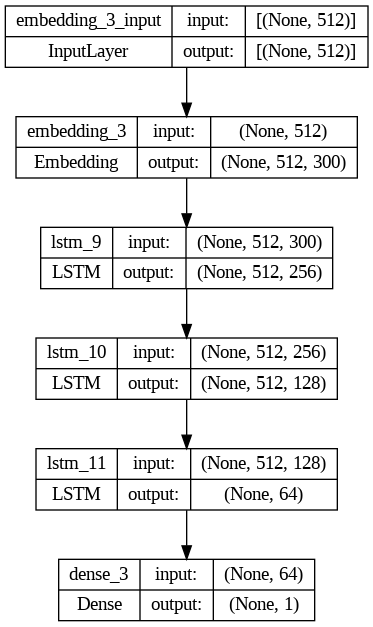

In [97]:
tf.keras.utils.plot_model(
    lstm_model, to_file="model_layer.png", show_shapes=True
)

### Plot Accuracy on Train and Validation

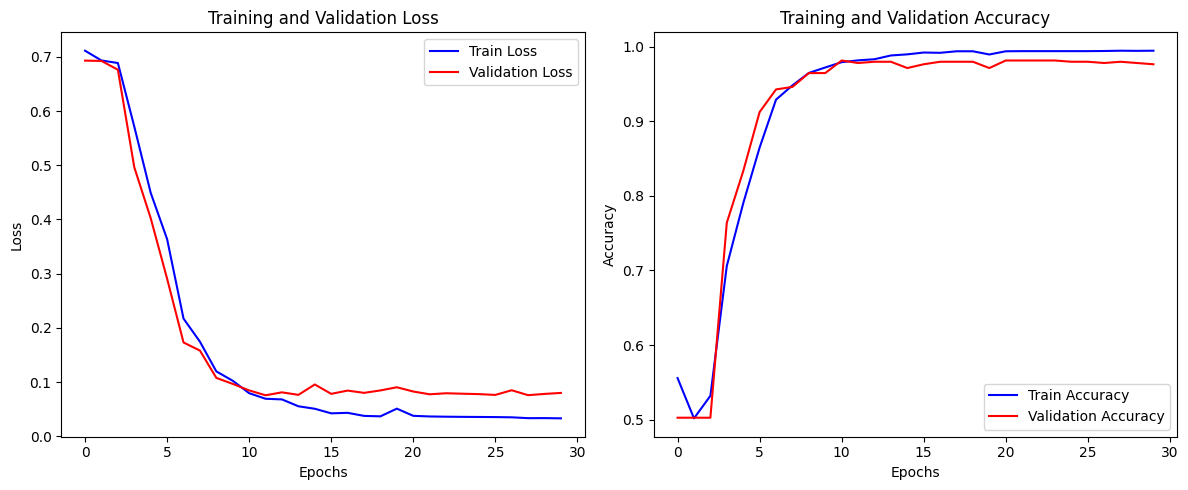

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(history_emd.history['loss'], c='b', label='Train Loss')
axs[0].plot(history_emd.history['val_loss'], c='r', label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

# Plot training and validation accuracy
axs[1].plot(history_emd.history['accuracy'], c='b', label='Train Accuracy')
axs[1].plot(history_emd.history['val_accuracy'], c='r', label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Testing and Evaluation

### Load model

In [99]:
from keras.models import load_model

model = load_model('lstm_model.h5')

In [100]:
pred = lstm_model.predict(X_test_pad)

19/19 [==============================] - 1s 32ms/step


Confuse Matrix


In [101]:
pred = lstm_model.predict(X_test_pad)

19/19 [==============================] - 1s 27ms/step


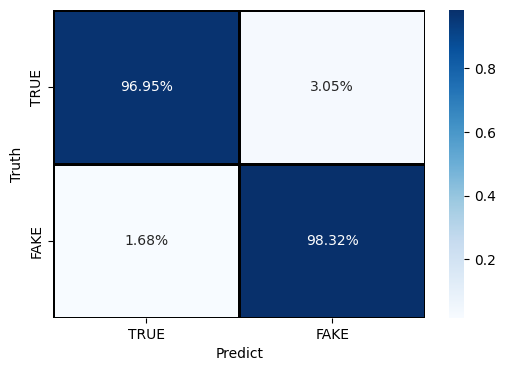

In [102]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, pred.round())
matrix_percent = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
matrix_percent_df = pd.DataFrame(matrix_percent, index=['TRUE', 'FAKE'], columns=['TRUE', 'FAKE'])
plt.figure(figsize=(6, 4))
sns.heatmap(matrix_percent_df, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2%', xticklabels=['TRUE', 'FAKE'])
plt.ylabel('Truth')
plt.xlabel('Predict')
plt.show()

In [103]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred.round())

print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       295
         1.0       0.97      0.98      0.98       298

    accuracy                           0.98       593
   macro avg       0.98      0.98      0.98       593
weighted avg       0.98      0.98      0.98       593



### Load data test

In [104]:
df_test = pd.read_csv('/content/drive/MyDrive/PBL6/dataimprove.csv')

In [105]:
df_test

,Unnamed: 0,Title,Link,Content
0,0,Hội luận trực tuyến “75 năm Quốc Tế Nhân Quyền...,https://viettan.org/hoi-luan-truc-tuyen-75-nam...,Hội luận trực tuyến chủ đề “75 năm Quốc Tế Nhâ...
1,1,Việt Tân kính tiễn biệt Đại lão Hòa Thượng Thí...,https://viettan.org/viet-tan-kinh-tien-biet-da...,"Đại lão Hòa Thượng Thích Tuệ Sỹ, một vị giáo p..."
2,2,Ai là người ‘chống lưng’ cho bà Trương Mỹ Lan?,https://viettan.org/ai-la-nguoi-chong-lung-cho...,"Bà Trương Mỹ Lan, chủ tập đoàn Vạn Thịnh Phát,..."
3,3,Bố già nào đằng sau Trương Mỹ Lan Vạn Thịnh Phát,https://viettan.org/bo-gia-nao-dang-sau-truong...,"Với 90% cổ phần ở Ngân hàng SCB, bà Trương Mỹ ..."
4,4,"Còn hơn 3 tháng mới đến Tết, nhiều công nhân n...",https://viettan.org/con-hon-3-thang-moi-den-te...,Vợ chồng chị Nhàn quê ở Bình Phước đang bắt đầ...
...,...,...,...,...
579,293,Thông cáo báo chí Kỳ họp thứ 34 của Ủy ban Kiể...,https://vtv.vn/chinh-tri/thong-cao-bao-chi-ky-...,"Đồng chí Trần Cẩm Tú, Ủy viên Bộ Chính trị, Bí..."
580,294,Chủ tịch nước dự Hội nghị sơ kết 5 năm triển k...,https://vtv.vn/chinh-tri/chu-tich-nuoc-du-hoi-...,"Sáng 20/12, Ban Chỉ đạo 35 Trung ương đã tổ ch..."
581,295,Giám đốc Công an tỉnh Nghệ An được điều động l...,https://vtv.vn/chinh-tri/giam-doc-cong-an-tinh...,"Ngày 19/12/2023, tại Hà Nội, Thượng tướng Lươn..."
582,296,Tổng Bí thư Nguyễn Phú Trọng dự Hội nghị Đảng ...,https://vtv.vn/chinh-tri/tong-bi-thu-nguyen-ph...,"Tham dự có Chủ tịch nước Võ Văn Thưởng, Thủ tư..."


In [106]:
df_test = df_test[['Title', 'Content']]

In [107]:
df_test['Label'] = 1
df_test['Label'][:286] = 0

<ipython-input-107-eb5e2b6a33c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Label'] = 1
<ipython-input-107-eb5e2b6a33c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Label'][:286] = 0


In [108]:
df_test

,Title,Content,Label
0,Hội luận trực tuyến “75 năm Quốc Tế Nhân Quyền...,Hội luận trực tuyến chủ đề “75 năm Quốc Tế Nhâ...,0
1,Việt Tân kính tiễn biệt Đại lão Hòa Thượng Thí...,"Đại lão Hòa Thượng Thích Tuệ Sỹ, một vị giáo p...",0
2,Ai là người ‘chống lưng’ cho bà Trương Mỹ Lan?,"Bà Trương Mỹ Lan, chủ tập đoàn Vạn Thịnh Phát,...",0
3,Bố già nào đằng sau Trương Mỹ Lan Vạn Thịnh Phát,"Với 90% cổ phần ở Ngân hàng SCB, bà Trương Mỹ ...",0
4,"Còn hơn 3 tháng mới đến Tết, nhiều công nhân n...",Vợ chồng chị Nhàn quê ở Bình Phước đang bắt đầ...,0
...,...,...,...
579,Thông cáo báo chí Kỳ họp thứ 34 của Ủy ban Kiể...,"Đồng chí Trần Cẩm Tú, Ủy viên Bộ Chính trị, Bí...",1
580,Chủ tịch nước dự Hội nghị sơ kết 5 năm triển k...,"Sáng 20/12, Ban Chỉ đạo 35 Trung ương đã tổ ch...",1
581,Giám đốc Công an tỉnh Nghệ An được điều động l...,"Ngày 19/12/2023, tại Hà Nội, Thượng tướng Lươn...",1
582,Tổng Bí thư Nguyễn Phú Trọng dự Hội nghị Đảng ...,"Tham dự có Chủ tịch nước Võ Văn Thưởng, Thủ tư...",1


In [109]:
X = df_test['Content']

In [110]:
df_test['Content'] = df_test['Content'].apply(tokenizerVN)
df_test['Content'] = df_test['Content'].apply(preprocess)

<ipython-input-110-1c95eec6dcea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Content'] = df_test['Content'].apply(tokenizerVN)
<ipython-input-110-1c95eec6dcea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Content'] = df_test['Content'].apply(preprocess)


In [111]:
X = df_test['Content']

In [112]:
X =tokenizer.texts_to_sequences(X)
X_pad=pad_sequences(X,maxlen=256,padding='post')

In [113]:
y = df_test['Label']

In [114]:
pred_test = lstm_model.predict(X_pad)

19/19 [==============================] - 1s 21ms/step


In [115]:
pred_test[1]

array([0.99903464], dtype=float32)

Fake: 1 True: 0

In [116]:
true = 0
false = 0

for i in range(0,285):
  if (pred_test[i]>0.5):
      true = true + 1
  else: false = false + 1
print(true)
print(false)

263
22


In [117]:
true = 0
false = 0

for i in range(286,583):
  if (pred_test[i]>0.5):
      false = false + 1
  else: true = true + 1
print(true)
print(false)

173
124


In [118]:
text = 'Dự hội nghị có các Ủy viên Bộ Chính trị: Thường trực Ban Bí thư, Trưởng Ban Tổ chức Trung ương Trương Thị Mai; Bí thư Trung ương Đảng, Chủ nhiệm Ủy ban Kiểm tra Trung ương Trần Cẩm Tú; Giám đốc Học viện Chính trị Quốc gia, Chủ tịch Hội đồng Lý luận Trung ương Nguyễn Xuân Thắng. Bí thư Trung ương Đảng, Phó Thủ tướng Chính phủ Lê Minh Khái cùng dự.Tại hội nghị, nêu rõ các kết quả công tác kiểm tra, giám sát năm 2023, Phó Chủ nhiệm Thường trực Ủy ban Kiểm tra Trung ương Trần Văn Rón cho biết: Trong công tác lãnh đạo, chỉ đạo, hướng dẫn thực hiện, Ủy ban Kiểm tra Trung ương đã tham mưu Bộ Chính trị, Ban Bí thư ban hành Quy định số 110-QĐ/TW về luân chuyển cán bộ trong ngành Kiểm tra Đảng; Quy định số 117-QĐ/TW về xin lỗi và phục hồi quyền lợi của tổ chức đảng, đảng viên bị kỷ luật oan; Quy định số 131-QĐ/TW về kiểm soát quyền lực, phòng, chống tham nhũng, tiêu cực trong công tác kiểm tra, giám sát, thi hành kỷ luật đảng và trong hoạt động thanh tra, kiểm toán. Ủy ban Kiểm tra Trung ương cũng đã tham mưu, trình Bộ Chính trị Quy trình kiểm tra của Bộ Chính trị, Ban Bí thư cùng nhiều quy trình quan trọng khác.Hội nghị Toàn quốc triển khai nhiệm vụ công tác kiểm tra, giám sát năm 2024 - Ảnh 1.Đồng chí Trần Văn Rón, Ủy viên Trung ương Đảng, Phó Chủ nhiệm Thường trực Ủy ban Kiểm tra Trung ương trình bày báo cáo tại hội nghị. Ảnh: TTXVNĐối với việc thực hiện nhiệm vụ kiểm tra tổ chức đảng và đảng viên, ông Trần Văn Rón cho hay: Năm 2023, cấp ủy các cấp đã kiểm tra 57.486 tổ chức đảng và 323.979 đảng viên. Qua kiểm tra, cấp ủy các địa phương, đơn vị kết luận có 1.769 tổ chức đảng và 6.796 đảng viên có khuyết điểm, vi phạm; đã thi hành kỷ luật 11 tổ chức đảng và 312 đảng viên.Trong thời gian này, thực hiện kiểm tra khi có dấu hiệu vi phạm đối với 3.537 tổ chức đảng và 9.246 đảng viên, Ủy ban Kiểm tra các cấp đã kết luận có 2.315 tổ chức đảng và 7.395 đảng viên có vi phạm; phải thi hành kỷ luật 284 tổ chức đảng và 3.052 đảng viên; đã thi hành kỷ luật 216 tổ chức đảng và 2.645 đảng viên.Báo cáo tại Hội nghị cho thấy, năm 2023, cấp ủy các cấp giám sát 42.979 tổ chức đảng và 147.197 đảng viên, có 48.388 đảng viên là cấp ủy viên các cấp. Qua giám sát, cấp ủy các cấp đã kết luận 1.104 tổ chức đảng và 1.777 đảng viên có vi phạm, khuyết điểm, chuyển kiểm tra khi có dấu hiệu vi phạm 10 tổ chức và 32 đảng viên.Cấp ủy các cấp đã giải quyết, tố cáo với 8 tổ chức đảng, 225 đảng viên, qua giải quyết đã xác định 4 tổ chức đảng và 46 đảng viên có vi phạm, khuyết điểm; phải thi hành kỷ luật 4 tổ chức đảng và 37 đảng viên.Ủy ban Kiểm tra các cấp nhận được 25.401 đơn thư tố cáo, phản ánh tổ chức đảng, đảng viên; đã giải quyết 46 đơn tố cáo tổ chức đảng, 1.297 đơn tố cáo đảng viên. Ủy ban Kiểm tra các cấp đã giải quyết 36 tổ chức đảng, 1.034 đảng viên. Qua giải quyết, kết luận có 2 tổ chức đảng và 170 đảng viên phải thi hành kỷ luật, đã thi hành kỷ luật 143 đảng viên.y ban Kiểm tra các cấp đã tiến hành kiểm tra, giám sát việc kê khai tài sản, thu nhập đối với 7.393 đảng viên; qua kiểm tra, giám sát kết luận 239 đảng viên có vi phạm, khuyết điểm. Một số vi phạm, khuyết điểm được chỉ ra như giải trình về nguồn gốc tài sản, thu nhập chưa đầy đủ, rõ ràng, kê khai tài sản không đầy đủ thông tin, không thống nhất, không đúng theo mẫu, không đúng hình thức quy định…, để các tổ chức đảng, đảng viên khắc phục, rút kinh nghiệm.Năm 2023, cấp ủy các cấp và chi bộ đã thi hành kỷ luật 423 tổ chức đảng, tăng 2,92% so với năm 2022; thi hành kỷ luật 18.130 đảng viên, tăng 10,64% so với năm 2022, có 3.073 cấp ủy viên. Ủy ban Kiểm tra các cấp đã thi hành kỷ luật 183 tổ chức đảng và 6.302 đảng viên, có 1.975 cấp ủy viên, trong đó, Ủy ban Kiểm tra Trung ương thi hành kỷ luật 29 tổ chức đảng và 65 đảng viên.Theo thông tin tại hội nghị, Ủy ban Kiểm tra Trung ương đã đặt ra nhiều nhiệm vụ quan trọng trong năm 2024. Theo đó, cấp ủy, tổ chức đảng, Ủy ban Kiểm tra các cấp, nhất là người đứng đầu, cần nâng cao hơn nữa nhận thức và trách nhiệm đối với công tác kiểm tra, giám sát; tiếp tục tổ chức thực hiện nghiêm túc các quy định, quy chế, hướng dẫn của Ban Chấp hành Trung ương, Bộ Chính trị, Ban Bí thư và Ủy ban Kiểm tra Trung ương về công tác kiểm tra, giám sát, kỷ luật đảng. Tăng cường lãnh đạo, chỉ đạo, thực hiện và hướng dẫn cấp ủy, tổ chức đảng và Ủy ban Kiểm tra cấp dưới thực hiện công tác kiểm tra, giám sát, kỷ luật đảng. Thực hiện tốt các nhiệm vụ, giải pháp đã đề ra tại Kết luật số 34-KL/TW của Bộ Chính trị về Chiến lược kiểm tra, giám sát của Đảng đến năm 2030 và Kế hoạch số 52-KH/UBKTTW của Ủy ban Kiểm tra Trung ương.Năm 2024, Ủy ban Kiểm tra Trung ương tiếp tục rà soát, sửa đổi, bổ sung, hoàn thiện các quy chế, quy định, hướng dẫn, quy trình về công tác kiểm tra, giám sát và kỷ luật của Đảng đảm bảo đồng bộ, chặt chẽ, phù hợp với quy định của Đảng và các điều kiện thực tiễn. Ủy ban tập trung tiếp thu, hoàn thiện quy trình và các quy định để trình Bộ Chính trị, Ban Bí thư ban hành. Tổng kết việc thực hiện các quy chế phối hợp giữa Ủy ban Kiểm tra Trung ương với một số đảng đoàn, đảng ủy, ban cán sự đảng, trên cơ sở đó ban hành các quy chế phối hợp mới.Ủy ban Kiểm tra các cấp tích cực tham mưu giúp cấp uỷ xây dựng, triển khai thực hiện chương trình công tác kiểm tra, giám sát năm 2024. Đẩy mạnh thực hiện toàn diện các nhiệm vụ theo quy định của Điều lệ Đảng. Tăng cường công tác kiểm tra, giám sát việc phòng, chống tham nhũng, tiêu cực, lãng phí; việc thực hiện các quy định của Đảng, pháp luật của Nhà nước.Ủy ban Kiểm tra các cấp tập trung kiểm tra khi có dấu hiệu vi phạm các lĩnh vực dễ phát sinh tham nhũng tiêu cực, những vấn đề nổi cộm, bức xúc trong xã hội, nội bộ mất đoàn kết, dư luận xã hội quan tâm, nhất là dấu hiệu suy thoái về tư tưởng chính trị, đạo đức, lối sống, "tự diễn biến", "tự chuyển hóa"; vi phạm trong những lĩnh vực chuyên môn sâu, hoạt động có tính khép kín…'

In [119]:
text = [text]

In [120]:
X_seq = tokenizer.texts_to_sequences(text)
X_pad=pad_sequences(X_seq, maxlen = 256, padding='post')

In [121]:
predictions = lstm_model.predict(X_pad)

1/1 [==============================] - 0s 26ms/step


In [122]:
predictions

array([[0.7543493]], dtype=float32)

In [123]:
predictions

array([[0.7543493]], dtype=float32)

In [124]:
if predictions >= 0.5:
    print("tin giả.")
else:
    print("tin thật.")

tin giả.
